# Bone age prediction of hand radiographs using Neural Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

%matplotlib inline
np.random.seed(1)

IMG_SIZE = 224
batch_size = 32

## Retrieve datasets

In [3]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

# Extract data from zip file
for data_dir in data_dirs:
  if not os.path.exists(data_dir):
      with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
          f.extractall('.')
  if 'Training' in data_dir: # training set has two more zip files
    for train_dir in train_dirs:
      if not os.path.exists(train_dir):
        with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
          f.extractall('.')
  if 'Validation' in data_dir: # validation set is divided in two more zip files
    for val_dir in val_dirs:
      if not os.path.exists(val_dir):
        with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
          f.extractall('.')

In [4]:
# !cp -R /content/boneage-training-dataset /content/boneage-training-masked
# !mkdir /content/boneage_training_masked
# !rm -r "/content/Bone Age Training Set"
# !mv "/content/Bone Age Validation Set/Validation Dataset.csv" /content
# !rm -r "/content/Bone Age Validation Set"

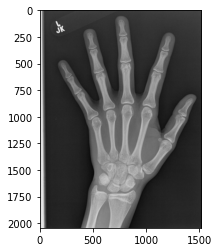

In [5]:
plt.imshow(cv2.imread(train_dirs[0] + '/1377.png'))

Mask an image as example

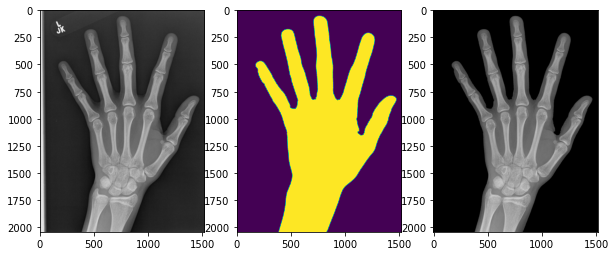

In [6]:
masks_path = 'boneage-training-dataset-masks'
image = cv2.imread(train_dirs[0] + '/1377.png')
mask = cv2.imread(path + '/' + masks_path + '/1377.png', 0)

fig, ax = plt.subplots(1,3, figsize=(10, 7))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(cv2.bitwise_and(image, image, mask=mask))

## Creating dataframes

In [7]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/utils.py" utils.py
from utils import *

train_df = load_filenames('train.csv', train_dirs[0])
validation_df = load_filenames(data_dirs[1] + '/Validation Dataset.csv', val_dirs[0], val_dirs[1])
test_df = load_filenames(data_dirs[2] + '/Bone age ground truth.xlsx', data_dirs[2] + '/Test Set Images')

# normalize boneage value to accelerate training
mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()
train_df['boneage_n'] = (train_df['boneage'] - mean_bone_age) / std_bone_age
validation_df['boneage_n'] = (validation_df['boneage'] - mean_bone_age) / std_bone_age
test_df['boneage_n'] = (test_df['boneage'] - mean_bone_age) / std_bone_age

# number of steps between epochs
train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))

In [8]:
display(train_df[:5])
display(validation_df[:5])
display(test_df[:5])

,image,gender(M/F),boneage,boneage_n
0,boneage-training-dataset/1377.png,0,180,1.279181
1,boneage-training-dataset/1378.png,0,12,-2.800269
2,boneage-training-dataset/1379.png,0,94,-0.809109
3,boneage-training-dataset/1380.png,1,120,-0.177766
4,boneage-training-dataset/1381.png,0,82,-1.100498


,image,gender(M/F),boneage,boneage_n
0,boneage-validation-dataset-1/1386.png,0,30,-2.363185
1,boneage-validation-dataset-1/1392.png,1,162,0.842097
2,boneage-validation-dataset-1/1397.png,0,18,-2.654575
3,boneage-validation-dataset-1/1401.png,0,132,0.113624
4,boneage-validation-dataset-1/1410.png,1,57,-1.707559


,image,gender(M/F),boneage,boneage_n
0,Bone Age Test Set/Test Set Images/4360.png,1,168.934249,1.010477
1,Bone Age Test Set/Test Set Images/4361.png,1,169.652678,1.027922
2,Bone Age Test Set/Test Set Images/4362.png,1,73.256112,-1.312821
3,Bone Age Test Set/Test Set Images/4363.png,1,152.862669,0.620220
4,Bone Age Test Set/Test Set Images/4364.png,1,135.456954,0.197567


## Data augmentation, Batching, Normalization

In [9]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

## Models for prediction

We use the mean absolute error as metric, as suggested in the papers

In [10]:
def mae_in_months(x, y):
    """
    Return mean absolute error in months

    Arguments:
    x -- predicted value
    y -- ground-truth
    """
    return mean_absolute_error((std_bone_age*x + mean_bone_age), (std_bone_age*y + mean_bone_age)) 

### InceptionV4
In this case we took the First-place replacing the Inception V3 model with an Inception V4, with the result of concatenating the 32-dimension vector corresponding to the gender with the pixels' vector of 75,264 dimensions (instead of 100,352)

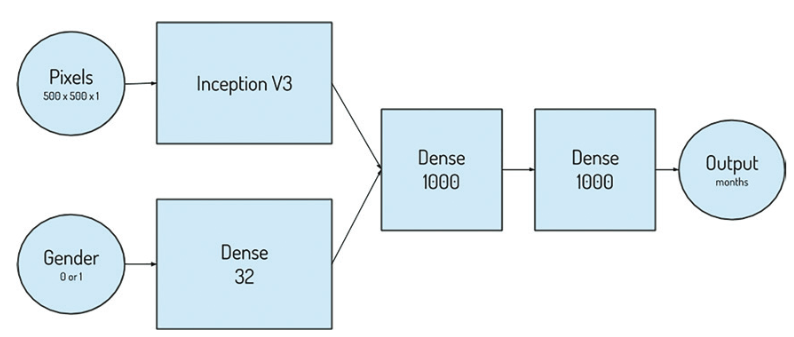

In [11]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py
from inc_v4 import *

incV4_model = Bone_Age_incV4((IMG_SIZE, IMG_SIZE, 1))
incV4_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])

### Simple CNN
Here we used a simple multi-layer convolution network 


In [12]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/simple_conv.py" simple_conv.py
from simple_conv import *

conv_model = Simple_Conv((IMG_SIZE, IMG_SIZE, 1))
conv_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])

## Model comparison

Create the callbacks for the fit function

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', 
                                min_delta=0.0001, cooldown=0, min_lr=0)

In [14]:
incV4_model_history = incV4_model.fit(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, 
                      validation_steps=val_steps, epochs=1, callbacks=[early_stopping, reduce_lr])
incV4_model_history

Found 12611 validated image filenames.
Found 12611 validated image filenames.
395/395 [==============================] - ETA: 0s - loss: 0.8488 - mae_in_months: 34.9544Found 1425 validated image filenames.
Found 1425 validated image filenames.
395/395 [==============================] - 963s 2s/step - loss: 0.8488 - mae_in_months: 34.9544 - val_loss: 0.8017 - val_mae_in_months: 33.0146 - lr: 0.0010


In [15]:
conv_model_history = conv_model.fit(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, 
                      validation_steps=val_steps, epochs=1, callbacks=[early_stopping, reduce_lr])
conv_model_history

395/395 [==============================] - 878s 2s/step - loss: 0.7893 - mae_in_months: 32.5055 - val_loss: 0.7859 - val_mae_in_months: 32.3648 - lr: 0.0010


In [ ]:
# test_gen.reset()
y_pred = incV4_model.predict(test_gen)
predict = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predict)
print("months predicted: " + str(predicted_months[i]) + ", real boneage: " + str(test_df.loc[i, 'boneage']) for i in range(len(predicted_months)))